In [16]:
import torch
from torch.utils.data import Dataset
import cv2
import os 
import numpy as np

class ColorizationDataset(Dataset):
    def __init__(self, image_folder, transform = None):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_bgr = cv2.imread(self.image_paths[idx])
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        img = cv2.resize(img_lab, (64, 64))

        L = img[:, :, 0] / 255.0
        ab = img[:, :, 1:] - 128
        if self.transform:
            L, ab = self.transform(L, ab)

        return L, ab

class ToTensorTransform:
    def __call__(self, L, ab):
        L = torch.from_numpy(L).unsqueeze(0).float()
        ab = torch.from_numpy(ab).permute(2,0,1).float()
        return L, ab

In [30]:
from torch.utils.data import DataLoader, random_split

dataset = ColorizationDataset(image_folder = 'data', transform = ToTensorTransform())
total_size = len(dataset)
train_size = int(.9 * total_size)
test_size = total_size - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])
val_size = int(.3 * train_size)
train_size = train_size - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True)

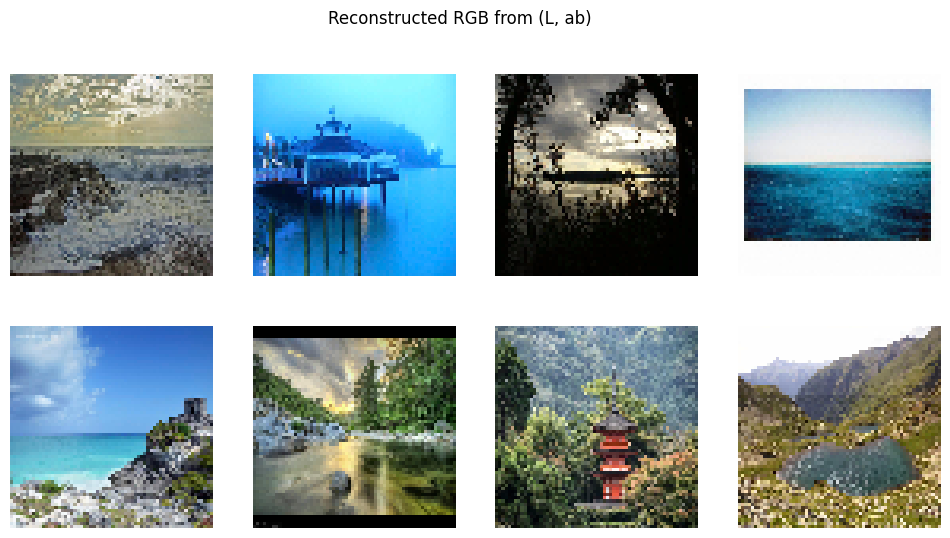

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

L_batch, ab_batch = next(iter(train_loader))

def lab_to_rgb(L, ab):
    L = np.squeeze(L)
    ab = np.transpose(ab, (1,2,0)) if ab.ndim == 3 else ab
    L = L * 255.0 
    ab = ab + 128
    lab = np.concatenate([L[..., np.newaxis], ab], axis = 2).astype(np.uint8)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb


plt.figure(figsize = (12, 6))
for i in range(8):
    L = L_batch[i].numpy()
    ab = ab_batch[i].numpy()
    rgb = lab_to_rgb(L, ab)

    plt.subplot(2,4,i+1)
    plt.imshow(rgb)
    plt.axis('off')
    
plt.suptitle("Reconstructed RGB from (L, ab)")
plt.show()

In [32]:
import torch.nn as nn 
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 2, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.downsample = nn.ModuleList()
        for feature in features:
            self.downsample.append(self._conv_block(in_channels, feature))
            in_channels = feature
        
        self.bottleneck = self._conv_block(features[-1], features[-1] * 2)

        self.upsample = nn.ModuleList()
        self.upconvs = nn.ModuleList()


        for feature in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(feature*2, feature, kernel_size = 2, stride = 2))
            self.upsample.append(self._conv_block(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

    
    def forward(self, x):
        skip_conns = []
        for down in self.downsample:
            x = down(x)
            skip_conns.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = self.bottleneck(x)

        skip_connections = skip_conns[::-1]
        for idx in range(len(self.upsample)):
            x = self.upconvs[idx](x)
            skip = skip_connections[idx]

            if x.shape != skip.shape:
                x = F.pad(x, self._get_padding(x, skip))
            
            x = torch.cat((skip, x), dim = 1)
            x = self.upsample[idx](x)
        return self.final_conv(x)
    
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def _get_padding(self, x, target):
        diff_y = target.size(2) - x.size(2)
        diff_x = target.size(3) - x.size(3)
        return [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2]

In [33]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('cuda')
model = UNet(in_channels = 1, out_channels=2).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 5)

In [34]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for L, ab in train_loader:
        L, ab = L.to(device), ab.to(device)
        pred_ab = model(L)
        loss = criterion(pred_ab, ab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for L, ab in val_loader:
            L, ab = L.to(device), ab.to(device)
            pred_ab = model(L)
            val_loss += criterion(pred_ab, ab).item()
    val_loss /= len(test_loader)
    scheduler.step(val_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f}')

Epoch 1/100 | Loss: 2031784.5605 | Val Loss: 90883.2931
Epoch 2/100 | Loss: 2699103.2441 | Val Loss: 52341.2059
Epoch 3/100 | Loss: 1384342.4072 | Val Loss: 36869.3683
Epoch 4/100 | Loss: 1200508.2236 | Val Loss: 35206.1078
Epoch 5/100 | Loss: 1155103.8203 | Val Loss: 34850.2901
Epoch 6/100 | Loss: 1149372.8486 | Val Loss: 40592.0612
Epoch 7/100 | Loss: 1137240.1758 | Val Loss: 36251.0493
Epoch 8/100 | Loss: 1131578.6152 | Val Loss: 35497.5950
Epoch 9/100 | Loss: 1138299.6035 | Val Loss: 36046.7807
Epoch 10/100 | Loss: 1124000.1084 | Val Loss: 41216.5194
Epoch 11/100 | Loss: 1150764.2461 | Val Loss: 34279.1696
Epoch 12/100 | Loss: 1113610.3828 | Val Loss: 33962.4173
Epoch 13/100 | Loss: 1112242.3252 | Val Loss: 34026.2863
Epoch 14/100 | Loss: 1099310.9004 | Val Loss: 33713.8043
Epoch 15/100 | Loss: 1116858.5430 | Val Loss: 33712.1062
Epoch 16/100 | Loss: 1105359.8965 | Val Loss: 34267.9418
Epoch 17/100 | Loss: 1110387.4297 | Val Loss: 33807.9117
Epoch 18/100 | Loss: 1098999.8379 | Val 

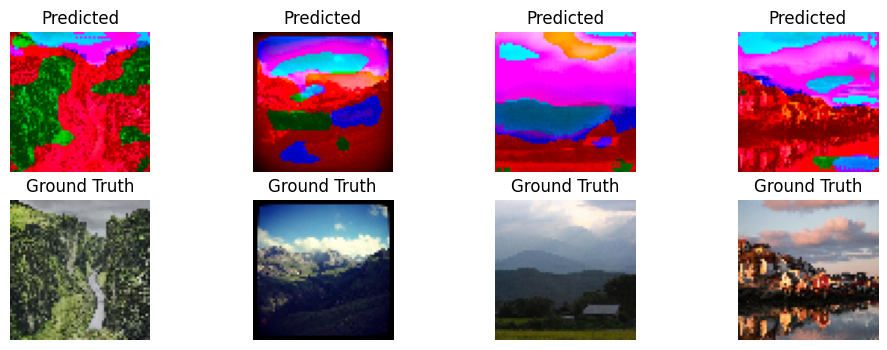

In [36]:
def lab_to_rgb(L, ab):
    L = L.squeeze().cpu().numpy() * 255.0 
    ab = ab.squeeze().cpu().numpy() + 128 

    lab = np.zeros((L.shape[0], L.shape[1], 3), dtype = np.uint8)
    lab[:,:,0] = L.astype(np.uint8)
    lab[:,:,1:] = ab.transpose(1,2,0).astype(np.uint8)

    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

model.eval()
with torch.no_grad():
    for L, ab in test_loader:
        L = L.to(device)
        pred_ab = model(L)
        break

plt.figure(figsize = (12, 4))
for i in range(4):
    rgb = lab_to_rgb(L[i], pred_ab[i])
    real_rgb = lab_to_rgb(L[i], ab[i])
    plt.subplot(2,4,i+1)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("Predicted")

    plt.subplot(2,4,i+5)
    plt.imshow(real_rgb)
    plt.axis('off')
    plt.title("Ground Truth")

plt.show()